# Metodologia: CRISP-DM

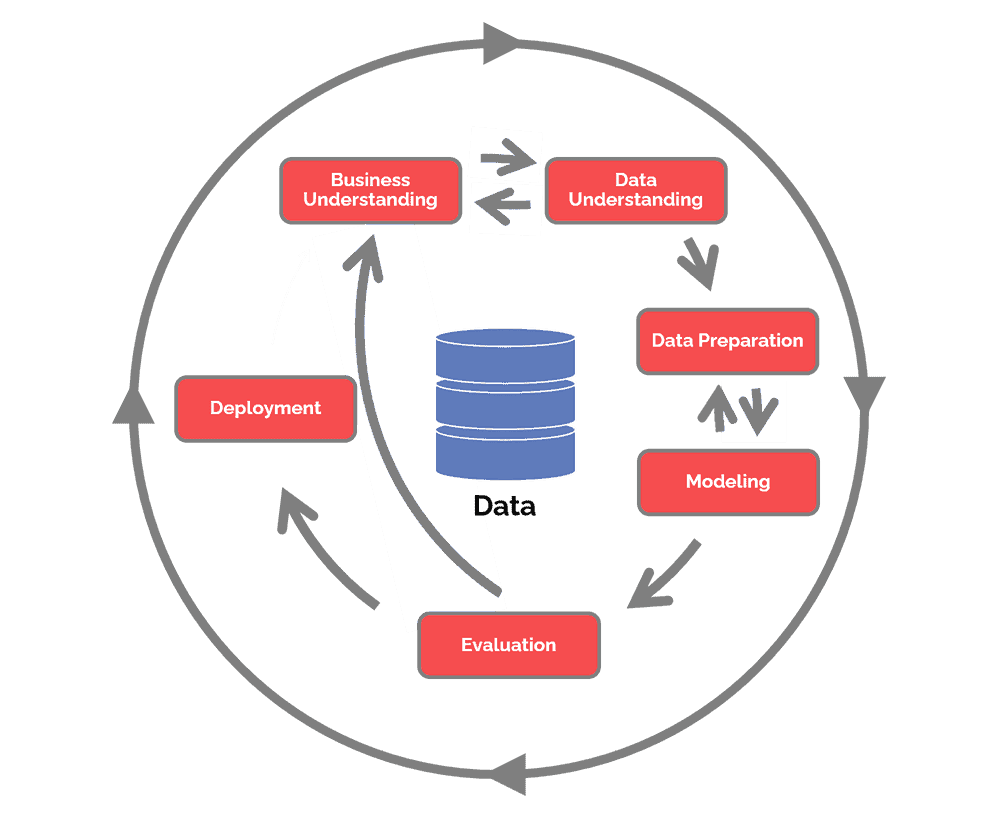

In [ ]:
# Libraries
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)
%matplotlib inline

# Questão A (classificação)

# 1. Business Understanding

Proposta do case:

a) Um falso positivo ocorre quando classificamos um cliente como insatisfeito, mas ela não se comporta como tal. Neste caso, o custo de preparar e executar uma ação de retenção é um valor fixo de 10 reais por cliente. Nada é ganho pois a ação de retenção não é capaz de mudar o comportamento do cliente. Um falso negativo ocorre quando um  liente é previsto como satisfeito, mas na verdade ele estava insatisfeito. Neste caso, nenhum dinheiro foi gasto e nada foi ganho. Um verdadeiro positivo é um cliente que estava insatisfeito e foi alvo de uma ação de retenção. O benefício neste caso é o lucro da ação (100 reais) menos os custos relacionados à ação de retenção (10 reais).  or fim, um verdadeiro negativo é um cliente insatisfeito e que não é alvo de nenhuma ação. O benefício neste caso é zero, isto é, nenhum custo, mas nenhum lucro. A  rimeira tarefa deste case é maximizar o lucro esperado por cliente considerando o contexto descrito no parágrafo acima.

O objetivo do negócio nesse estudo é gerar informação relacionada a satisfação dos clientes a partir de uma base de dados para uma possível ação de retenção. 

O item "a" trata-se de um problema de classificação, onde o objetivo é classificar corretamente os clientes em "Satisfeito" ou "Insatisfeito" maximizando o lucro por cliente. 

Dado que o objetivo principal é a maximização do lucro, podemos analisar a matriz de confusão através do seguinte aspecto:\
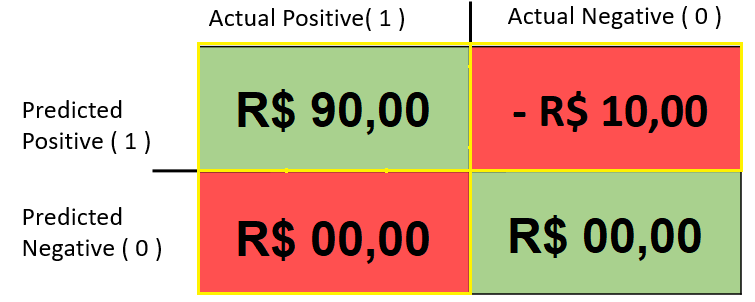

O contorno em amarelo indica os quadrantes mais importantes para o objetivo do projeto. Para maximizar o lucro devemos aumentar o recall (TP/TP+FN) controlando tabém o a precisão. O Recall está relacionado a maximização do lucro, enquanto o "precision" controla o custo das ações efetivadas em clientes já satisfeitos. Essas duas métricas estão fortemente relacionadas ao lucro que será a métrica chave desse projeto.

# 2. Data Understanding

Os dados disponíveis são sintéticos, anonimizados e não possuem alguma informação quanto ao significado das features. Isso implica em algumas dificuldades quanto às tomadas de decisão durante o desenvolvimento da solução.

### 2.1 Carregando datasets

In [ ]:
# Função de carregamento dos dados
def DataLoading():
    df_train = pd.read_csv("../input/santander-customer-satisfaction/train.csv")
    df_test = pd.read_csv("../input/santander-customer-satisfaction/test.csv")
    
    # Quantidade de colunas e registros de cada dataset carregado
    print('Dataset de treino: ',df_train.shape,'\nDataset de teste: ', df_test.shape)
    
    # Retorna datasets
    return df_train, df_test

# Executa carregamento e guarda em memória
df_train, df_test = DataLoading()

### 2.2 Distribuição da target

In [ ]:
# Contagem de registros por classe
target_couts  = df_train.iloc[:,-1].value_counts()
insatisfeitos = target_couts[1]
satisfeitos   = target_couts[0]

# Proporção em %
prop = (insatisfeitos/satisfeitos)*100
print('\nA variável target do treino possui {}% de positivos, isso significa que a target é desbalanceada.'.format(round(prop,2)))

# Recurso visual
plt.bar(target_couts.index,target_couts,color='red')
plt.xticks([0,1])
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.title('Quantidade de registros por classe');

### 2.3 Tipo de dados presentes nas colunas

In [ ]:
# Contagem de colunas por tipo de dados
tipos_dados = df_train.dtypes.value_counts()

# Recurso visual
plt.bar(tipos_dados.index.astype(str), tipos_dados.values, color='red')
plt.ylabel('Quantidade')
plt.title('Quantidade de colunas por tipo de dados')
print("\nTemos apenas variaveis numéricas no dataset, isso facilitará a preparação de dados.")

### 2.4 Visão geral

In [ ]:
# Exemplo da primeiras colunas do dataset
df_train.head()

In [ ]:
print('\nPodemos observar que temos variáveis com diferentes escalas.\n')

# Algumas métricas por coluna, para ter uma noção
df_train.describe()

### 2.5 Valores ausentes

In [ ]:
# Contagem de valores ausentes por coluna
print("Quantidade de valores ausentes por coluna: \n",np.array((len(df_train)-df_train.count())/76020))
print('\n O dataset não possui valores ausentes.')

# 3 Data Prepatarion

### 3.1 Limpeza de registros duplicados

In [ ]:
# Função que deleta registros duplicados da base (Mantendo apenas o primeiro registro a cada grupo de duplicatas)
def DupRegClean(df):
    # Registros duplicados podem causar ruído nos algoritmos de machine learning portanto iremos excluí-los.
    # (Se por acaso colunas duplicadas estierem presentes nos datasets de treino e teste, os resultados podem se mostrar tendenciosos).
    print('df antes: ',df.shape)
    df_saida = df.drop_duplicates(inplace=False,keep='first')
    print('Após a limpeza de registros duplicados: ',df_saida.shape)
    return df_saida

# Aplica limpeza
df_train = DupRegClean(df_train)

### 3.2 Colunas constantes

In [ ]:
# Função que deleta colunas constantes do dataset
def ConstFeatClean(df_train):
    # Colunas constantes não são úteis para discriminar a satisfação de clientes. Vamos exclui-las.
    print('df antes: ',df_train.shape)
    df_train = df_train.loc[:,df_train.apply(pd.Series.nunique) != 1]
    print('Após limpeza de colunas constantes: ',df_train.shape)
    return df_train

# Aplica função de deleção de contantes
df_train = ConstFeatClean(df_train)

### 3.3 Train Test Split

In [ ]:
# Separando as variáveis da target
X = df_train.iloc[:,:-1]
y = df_train.iloc[:,-1]

# Dividindo o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)

# Observando as proporções de classes nas targets do dataset de treino e teste (o objetivo é ter uma proporção semelhante)
fig,ax = plt.subplots(figsize=(8,6))
treino_b = ax.bar(y_train.value_counts().index-0.2,y_train.value_counts().values,0.4, color='gray',label='Dataset Treino')
teste_b  = ax.bar( y_test.value_counts().index+0.2,y_test.value_counts().values ,0.4, color='red' , label='Dataset Teste')

# Percentuais
perc_tr = (y_train.value_counts().values[1]/y_train.value_counts().values[0])*100
print('\nO dataset de treino possui: ',round(perc_tr,2),'% de classes positivas')
perc_ts = (y_test.value_counts().values[1]/y_test.value_counts().values[0])*100
print('\nO dataset de teste possui: ',round(perc_ts,2),'% de classes positivas')

# Recurso visual
ax.set_ylabel('Quantidade')
ax.set_xlabel('Target')
ax.set_title('Proporção de classes na variavel target')
ax.set_xticks([0,1])
ax.legend()
ax.bar_label(treino_b, padding=3)
ax.bar_label(teste_b,  padding=3)
fig.tight_layout()
plt.show()

### 3.4 Feature Transformations

In [ ]:
# Padronização das features para aplicação do modelo
scaler = StandardScaler()

# Colunas selecionadas até agora
cols = X_train.columns

# Transformação
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)
X       = scaler.transform(X[cols])
df_test = scaler.transform(df_test[cols])

# Variancia total do dataframe após a padronização
std_apos = X_train.std()
print('Desvio padrão após a padronização: ', round(std_apos,2))

# Transformando os datasets em pandas dataframes para maior facilidade de manipulação
X       = pd.DataFrame(X,       columns=scaler.get_feature_names_out())
df_test = pd.DataFrame(df_test, columns=scaler.get_feature_names_out())
X_train = pd.DataFrame(X_train, columns=scaler.get_feature_names_out())
X_test  = pd.DataFrame(X_test , columns=scaler.get_feature_names_out())

### 3.5 Data Cleaning

Limpeza de features correlacionadas

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class CorrelatedFeatDrop(BaseEstimator, TransformerMixin):
    def __init__(self, dropCorrT=0.8):
        self.dropCorrT = dropCorrT
        
    def fit(self,X,y=None):
        def corr_drop(corr_m, factor):
            global cm
            cm = corr_m
            cum_corr = cm.applymap(abs).sum()
            # Função que busca os scores de correlação entre cada variável, vairáveis com alta correlação serão excluídas
            def remove_corr():
                global cm
                for col in cm.columns:
                    for ind in cm.index:
                        if (ind in cm.columns) and (col in cm.index):
                            if (cm.loc[ind,col] > factor) and (ind!=col):
                                cum = cum_corr[[ind,col]].sort_values(ascending=False)
                                cm.drop(cum.index[0], axis=0, inplace=True)
                                cm.drop(cum.index[0], axis=1, inplace=True)
                                # Do recursion until the last high correlated.
                                remove_corr()
                return cm
            return remove_corr()
        
        self.corr_chosen_features = corr_drop(X.corr(), self.dropCorrT).columns
                
        return self
    
    def transform(self,X,y=None):
        print('\nDataframe Inicial: ',X.shape)
        qtd_col_ini = X.shape[1]
        
        X = X[self.corr_chosen_features]        
        print('Após exclusão de colunas correlacionadas: ',X.shape)
        qtd_col_fim = X.shape[1]
        print('Quantidade de colunas dropadas: ',qtd_col_ini-qtd_col_fim)
        
        return X

dc = CorrelatedFeatDrop()
X_train = dc.fit_transform(X_train)
X_test  = dc.transform(X_test)

### 3.6 Feature Selection

A Seleção de features inicial será executada aliando 2 metodos:

* Teste de correlação linear ANOVA
* Teste de correlação não-linear de informações mutuas (Mutual Information)

O objetivo é descobrir e excluir as variaveis menos correlacionadas à target tanto de forma linear quanto não-linear

In [ ]:
from sklearn.feature_selection import SelectPercentile
# ANOVA f-test 
from sklearn.feature_selection import f_classif
# Mutual Information 
from sklearn.feature_selection import mutual_info_classif

np.random.seed(42)

def StatsFeatureSelection (X_train, y_train, X_test, p_valor=0.05):
    # ANOVA f-teste
    fs = SelectPercentile(score_func=f_classif) # (p_valor=0.05) De acordo com alguns testes o percentil 50 ja possui variaveis acima do p-valor, filtramos aqui para melhorar a performance
    # Aprende a relação das features com a target
    fs.fit(X_train, y_train)
    
    # Teste de informação mutua (Mutual Information test)
    fs1 = SelectPercentile(score_func=mutual_info_classif, percentile=100) # Trazer 100 percentis, significa buscar todas as variáveis e seus scores
    # Aprende a relação das features com a target
    fs1.fit(X_train, y_train)

    # No teste f ANOVA, assumindo um p-valor de 0.05, podemos utiliaza-lo para definir o ponto de corte que separa as features importantes para o modelo das features que não possuem relação significativa com a target
    ANOVA_stats = pd.DataFrame({"Feature":fs.feature_names_in_,
                                  "Score":fs.scores_,
                                 "pValue":fs.pvalues_})
    ANOVA_stats = ANOVA_stats[ANOVA_stats['pValue'] <= p_valor]
    fs_ANOVA_best = ANOVA_stats['Feature'].values
    
    # No teste de informação mutua não temos o apoio do p-valor, portanto vamos utilizar um recurso visual para efetuar o corte
    MI_stats = pd.DataFrame({"Feature":fs1.feature_names_in_,
                               "Score":fs1.scores_}).sort_values('Score',ascending=False)
    plt.plot(range(len(MI_stats['Feature'])),MI_stats['Score'], color='red')
    plt.show()
    # De acordo com o gráfico, após as melhores 40 features não temos uma grande diferença de importancia e o que sobra são variaves muito pouco relacionadas com a target
    fs_MI_best = MI_stats.head(40)['Feature'].values
    
    # Shape dos datasets antes
    print('\nDataset de treino antes do corte: ',X_train.shape)
    print('Dataset de teste antes do corte:  ',X_test.shape)
    
    # Seleção de features aliando os métodos
    X_train = X_train[np.union1d(fs_ANOVA_best,fs_MI_best)]
    X_test  = X_test[np.union1d(fs_ANOVA_best,fs_MI_best)]
    
    return X_train, X_test

# Aplicando a função 
X_train, X_test = StatsFeatureSelection(X_train, y_train, X_test)

print('\nDataset de treino após o corte: ',X_train.shape)
print('Dataset de teste  após o corte: ',X_test.shape)

In [ ]:
# Backup do treino e teste (apenas para o desenvolvimento)
X_train_bkp = X_train.copy()
X_test_bkp  = X_test.copy()

# 4. Modeling

### 4.1 Métrica de avaliação

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

# Função que calcula o lucro das predições do algoritmo
def scoring(y_true, preds, verbose=False, **kwargs):
    
    # Tabela de confusão com (tn,fp,fn,tp)
    crosstab = metrics.confusion_matrix(y_true, preds)
    
    if len(preds) < 4:
        tn, fp, fn, tp = 0, 0, 0, 0
    else:
        tn, fp, fn, tp = crosstab.ravel()
    
    # Printar as variáveis caso verbose for igual a True
    if verbose:
        print('tp:', tp, ' fp:', fp, ' tn:',tn,'fn:', fn)
    
    # Calculo do lucro total
    lucro_tot = (tp*90 - fp*10)
    
    # Calculo do lucro por cliente classificado
    lucro_cli = lucro_tot/len(preds)
    
    return lucro_cli

# Gerando um "Scorer" do sklearn para aplicar a métrica de lucro ao grid-search no futuro
lucro = make_scorer(scoring, greater_is_better=True)

### 4.2 Performance de um modelo dumb (Burro) e o lucro máximo possível

In [ ]:
from sklearn.dummy import DummyClassifier

# Instancia-se o modelo burro
dc = DummyClassifier(strategy="most_frequent") # O Dummy classifier vai prever sempre a target mais frequente no dataset de treino

# Treino do modelo burro
dc.fit(X_train, y_train)

# Teste de performance
preds = dc.predict(X_test)
dumb_score = scoring(y_test, preds)

# Lucro caso a campanha impacte todos os clientes
lucro_todos_insatisfeitos = scoring(y_train, [1 for i in range(len(y_train))])

# Verificação do score máximo possível no treino
max_score_tr = (scoring(y_train, y_train))
# Verificação do score máximo possível no teste
max_score_ts = (scoring(y_test, y_test))

print('\nLucro do modelo dumb: R$',dumb_score)
print('\nLucro caso a campanha seja aplicada para toda a clientela: R$',round(lucro_todos_insatisfeitos,2))
print('\nO lucro máximo possível dado o conjunto de dados de treino é de: R$',round(max_score_tr,2))
print('\nO lucro máximo possível dado o conjunto de dados de teste é de: R$',round(max_score_ts,2))

### 4.3 Testes com diferentes tipos de algoritmos

O objetivo aqui é testar diferentes algoritmos de aprendizado de máquina para entender como se comportam com os dados atribuídos. Alguns deles ainda nos servirão de apoio para aplicar rodadas de seleção de features que mais discriminam a target em busca de maximizar o lucro.

Essa etapa será repetida no futuro, após novos ajustes de preparação de dados.

In [ ]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

# Parâmetros iniciais para cada algoritmo (Vamos buscar ajustar inicialmente os hiperparametros para trabalharem com a taget desbalanceada)
naive_bayes_params = [{}]
xgb_params         = [{"scale_pos_weight":25,"random_state":42}] # 100% de targets dividido pela quantidade de positivos (4%) = 25
kneighbors_params  = [{"weights":"distance"}] 
svc_params         = [{"class_weight":"balanced"}]
log_reg_params     = [{"class_weight":"balanced","max_iter":10000}]
dec_tree_params    = [{"class_weight":"balanced"}]
rand_for_params    = [{"class_weight":"balanced"}]

# Array auxiliar para organizar a iteração dos laços de repetição
modelclasses = [
     ["naive bayes",       GaussianNB,                 naive_bayes_params]
    ,["XGBoost",           XGBClassifier,                      xgb_params]
    ,["k neighbors",       KNeighborsClassifier,        kneighbors_params]
    ,["support vector classifier", LinearSVC,                  svc_params]
    ,["log regression",    LogisticRegression,             log_reg_params]
    ,["decision tree",     DecisionTreeClassifier,        dec_tree_params]
    ,["random forest",     RandomForestClassifier,        rand_for_params]
]

insights = []
# Laço de repetição que treina e testa cada algoritmo com seus respectivos hiperparâmetros
for modelname, Model, params_list in modelclasses:
    for params in params_list:
        model = Model(**params)
        cv_scores = cross_val_score(model, X_train, y_train, scoring=lucro, cv=3)
        score = round(cv_scores.mean(),2)
        score_stddev = round(cv_scores.std(),2)
        insights.append((modelname, model, params, score, score_stddev))
        
insights.sort(key=lambda x:x[-2], reverse=True)
# Laço que printa os resultados
modelnames = []
scores = []
for modelname, model, params, score, score_stddev in insights:
    print(modelname, 'Lucro: R$',score, ' Desvio Padr: R$',score_stddev)
    modelnames.append(modelname)
    scores.append(score)
    
# Recurso visual
plt.figure(figsize=(16,5))
plt.bar(modelnames, scores, color='red', yerr=score_stddev)
plt.ylabel('Lucro')
plt.xlabel('Algoritmo')
plt.title('Lucro total por algoritmo treinado')
plt.axis([-1,len(modelnames),-1,1.5])
print("\n O XGBoosting Teve performance melhor (de longe) comparado aos outros algoritmos, mesmo mantendo um desvio padrão semelhante.\n")

# 5. Data Prepatarion (Nº2)

#### 5.1 Analisando variáveis mais significativas para os modelos treinados

Capturando as features mais relevantes para a Decision Tree, Random Forest e XGBoosting. Capturando também os coefiscientes da regressão logística.

In [ ]:
def GetFeatureImportances():
    # Feature importance da arvore de decisão
    dt = DecisionTreeClassifier(class_weight='balanced')
    dt.fit(X_train,y_train)
    dec_tree_fi = pd.DataFrame({"Feature":X_train.columns,"Importance":dt.feature_importances_})

    # Feature importance do Random Forest
    rf = RandomForestClassifier(class_weight='balanced', random_state=42)
    rf.fit(X_train,y_train)
    rand_for_fi = pd.DataFrame({"Feature":X_train.columns,"Importance":rf.feature_importances_})

    # Coenficientes da Regressão logística
    rl = LogisticRegression(class_weight='balanced',max_iter=10000)
    rl.fit(X_train,y_train)
    log_reg_fi = pd.DataFrame({"Feature":X_train.columns,"Importance":abs(rl.coef_[0])})
    
    # Feature importance do Random Forest
    xgb = XGBClassifier(scale_pos_weight=25, random_state=42)
    xgb.fit(X_train,y_train)
    xgb_fi = pd.DataFrame({"Feature":X_train.columns,"Importance":xgb.feature_importances_})
    
    print('\nRetornados os datasets na ordem: Arvore de decisão, Random Forest, Regressão Logística e XGBoosting')
    
    return dec_tree_fi, rand_for_fi, log_reg_fi, xgb_fi

# Aplicação da função que retorna os scores de importância de cada feature
dec_tree_fi, rand_for_fi, log_reg_fi, xgb_fi = GetFeatureImportances()

Plotando ordenadamente as features mais relevantes para os modelos

In [ ]:
#Função que apresenta em gráficos como se comportam os scores do feature selection realizado anteriormente
def plot_feature_importances(fi1,fi2,fi3,fi4):
    pd.set_option('display.float_format', lambda x: '%.9f' % x)
    
    # Ordena os scores em ordem decrescente
    dec_tree_fi_sorted = fi1.sort_values(by='Importance',ascending=False)
    rand_for_fi_sorted = fi2.sort_values(by='Importance',ascending=False)
    log_reg_fi_sorted  = fi3.sort_values(by='Importance',ascending=False)
    xgb_fi_sorted      = fi4.sort_values(by='Importance',ascending=False)

    # Instancia gráfico
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, sharex=False,figsize=(18, 6))

    # Organiza os gráficos e eixos
    ax0.plot(range(len(dec_tree_fi_sorted['Importance']))
             ,dec_tree_fi_sorted['Importance'], '.', color='green',  label='Decision Tree')
    ax1.plot(range(len(rand_for_fi_sorted['Importance']))
             ,rand_for_fi_sorted['Importance'], '.', color='blue',   label='Random Forest');
    ax2.plot(range(len(log_reg_fi_sorted['Importance']))
             ,log_reg_fi_sorted['Importance'],  '.', color='red',    label='Logistic Regression');
    ax3.plot(range(len(xgb_fi_sorted['Importance']))
             ,xgb_fi_sorted['Importance'],      '.', color='orange', label='XGBoosting');
    
    # Aplica legenda
    ax0.legend(), ax1.legend(), ax2.legend(), ax3.legend()
    
    return dec_tree_fi_sorted,rand_for_fi_sorted,log_reg_fi_sorted,xgb_fi_sorted

# Aplicação da função
dec_tree_fi_sorted,rand_for_fi_sorted,log_reg_fi_sorted,xgb_fi_sorted = plot_feature_importances(dec_tree_fi, rand_for_fi, log_reg_fi, xgb_fi)

print('\nObservando o gráfico, é nítido que temos um conjunto de variáveis que possuem importância absolutamente maior do que o resto das features, portanto executaremos algo semelhante a técnia "Elbow" de clustering para selecionar o corte de váriaveis a serem testadas na sequência.\n')

Selecionando conjunto das melhores features de acordo com o gráfico

In [ ]:
# Aplica uma união entre as variáveis importantes para cada algoritmo para não perder nenhuma variável importante
best_features = np.union1d(dec_tree_fi_sorted.head(10)["Feature"].values
                           ,rand_for_fi_sorted.head(10)["Feature"].values)
best_features = np.union1d(best_features,log_reg_fi_sorted.head(10)["Feature"].values)
best_features = np.union1d(best_features,xgb_fi_sorted.head(15)["Feature"].values)

# Filtra colunas selecionadas
X_train = X_train[best_features]
X_test  = X_test[best_features]

print('Melhores features: ',best_features)
print('\nDataset de treino: ',X_train.shape)

# 6. Modeling (Nº2)

### 6.1 Testes com diferentes tipos de algoritmos

In [ ]:
# Novamente aplicamos o laço de repetição que treina e testa cada algoritmo com seus respectivos hiperparâmetros
insights = []
for modelname, Model, params_list in modelclasses:
    for params in params_list:
        model = Model(**params)
        cv_scores = cross_val_score(model, X_train, y_train, scoring=lucro, cv=3)
        score = round(cv_scores.mean(),2)
        score_stddev = round(cv_scores.std(),2)
        insights.append((modelname, model, params, score, score_stddev))
        
insights.sort(key=lambda x:x[-2], reverse=True)
for modelname, model, params, score, score_stddev in insights:
    print(modelname, 'Lucro: R$',score, 'Desvio Padr: R$',score_stddev)
    
# Recurso visual
plt.figure(figsize=(16,4))
plt.bar(modelnames, scores, color='red', yerr=score_stddev)
plt.ylabel('Lucro')
plt.xlabel('Algoritmo')
plt.title('Lucro total por algoritmo treinado')
plt.axis([-1,len(modelnames),-1,1.5])
print("\n O XGBoosting continua mantendo uma performance melhor comparado aos outros algoritmos, mesmo mantendo um desvio padrão semelhante.\n")  

Guardando colunas utilizadas no modelo

In [ ]:
colunas = X_train.columns

### 6.2 Hyperparameters tunning

De acordo com o ultimo teste geral, podemos escolher 3 algoritmos que se destacam, analisando o lucro obtido e o tipo de erro que eles cometem, o objetivo é continuar com os modelos com maior lucro e que cometem erros diferentes de classificação entre eles.

Seguiremos com:
* Random Forest
* Decision Tree
* XGBoosting

### Aprimoramento (Random Forest)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Instancia do algoritmo
rf = RandomForestClassifier(random_state=42)

# Definindo o espaço de procura
rf_grid = {'n_estimators': [100, 200]
           ,'max_features': ['auto', 'sqrt']
           ,'max_depth': [4, 5, 6]
           ,'min_samples_split': [2, 5, 8]
           ,'min_samples_leaf': [8, 10, 12]
           ,'class_weight':['balanced']
           ,'bootstrap':[True]}

# Define o grid search
rf_search = GridSearchCV(rf, rf_grid, scoring=lucro, cv = 3, verbose=1, n_jobs = -1, refit=False)

# Executa o grid search
result = rf_search.fit(X_train, y_train)
# Resultados
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

# Saída dessa célula ()
# Best Score: 0.6273787599754451
# Best Hyperparameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 12, 'min_samples_split': 2, 'n_estimators': 200}

### Aprimoramento (Arvore de Descisão)

In [ ]:
# Instancia do algoritmo
dt = DecisionTreeClassifier()

# Definindo o espaço de procura
dt_grid = {'min_samples_split': [1, 2, 3, 10, 30, 50,100]
           ,'min_samples_leaf': [1, 2, 3, 30, 300]
           ,'criterion':['gini', 'entropy']
           ,'max_depth':[1,2,3,4,5]
           ,'class_weight':['balanced']}

# Define o grid search
dt_search = GridSearchCV(dt, dt_grid, scoring=lucro, cv = 3, verbose=1, n_jobs = -1, refit=False)

# Executa o grid search
dt_result = dt_search.fit(X_train, y_train)
# Resultados
print('Best Score: %s' % dt_result.best_score_)
print('Best Hyperparameters: %s' % dt_result.best_params_)

# Saída dessa célula
# Best Score: 0.7480487590984829
# Best Hyperparameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}

### Aprimoramento (XGBoost)

In [ ]:
# Instancia do algoritmo
xgb = XGBClassifier(random_state=42)

# Definindo o espaço de procura
xgb_grid = {
            'max_depth':[4,5,6]
            ,'learning_rate':[0.001,0.01]
            ,'n_estimators':[100,200]
            ,'gamma':[5,15]
            ,'min_child_weight':[5, 10]
            ,'subsample':[0.6,0.8]
            ,'alpha':[8, 10]
            ,'scale_pos_weight':[25]}

# Define o grid search
xgb_search = GridSearchCV(xgb, xgb_grid, scoring=lucro, cv = 3, verbose=1, n_jobs = -1, refit=False)

# Executa o grid search
xgb_result = xgb_search.fit(X_train, y_train)
# Resultados
print('Best Score: %s' % xgb_result.best_score_)
print('Best Hyperparameters: %s' % xgb_result.best_params_)

# Saída dessa célula
# Best Score: 0.5931772340612119
# Best Hyperparameters: {'alpha': 8, 'gamma': 5, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'scale_pos_weight': 25, 'subsample': 0.6}

### 6.3 Análise de trashold

Dado que trata-se de um case para comprovação de conhecimento técnico, com o objetivo de ganhar tempo, iremos instanciar os algoritmos com base no grid search ao invés de utilizar a opção de "refit" dos mesmos (isso também explica o espaço pequeno de hiperparâmetros utilizado no gri search).

In [ ]:
# # Algoritmos só para teste
rf  = RandomForestClassifier(class_weight="balanced",random_state=42, bootstrap=True, 
                             max_depth=4, max_features='auto', min_samples_leaf=5, 
                             min_samples_split=10, n_estimators=200)
rf.fit(X_train,y_train)
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=2, min_samples_leaf=2, min_samples_split=5,criterion='entropy')
dt.fit(X_train,y_train)
xgb = XGBClassifier(max_depth=5, alpha=8, n_estimators=200, learning_rate=0.01, scale_pos_weight=25,random_state=42,gamma=5,
                    min_child_weight=10,subsample=0.8)
xgb.fit(X_train,y_train)
rf_search = rf
dt_search = dt
xgb_search = xgb

# Função que analisa os cortes de trashold dos algoritmos e seus respectivos lucros
def trashold_choice(models, model_names, trashold_range, X,y):
    scores = pd.DataFrame()
    scores['t_range'] = trashold_range
    for model,name in zip(models,model_names):
        proba = model.predict_proba(X)[:,1]
        scores_arr = []
        for i in trashold_range:
            classes = (proba >= i).astype(int)
            scores_arr.append(scoring(y, classes))
        scores[name] = scores_arr
    return scores

# Aplica função no treino
scores = trashold_choice([rf_search, dt_search, xgb_search], ['RandomForest','DecisionTree','XGB'], np.arange(0,1,0.05), X_train, y_train)
# Aplica função no treino
scores_ts = trashold_choice([rf_search, dt_search, xgb_search], ['RandomForest','DecisionTree','XGB'], np.arange(0,1,0.05), X_test, y_test)


# Recurso visual para escolha do melhor corte e análise de estabilidade no teste
plt.plot(scores['t_range'], scores['RandomForest'], "b-",color='red',    label='RF')
plt.plot(scores['t_range'], scores['DecisionTree'], "b-",color='blue',   label='DecisionTree')
plt.plot(scores['t_range'], scores['XGB'],          "b-",color='orange' ,label='XGB')
plt.plot(scores_ts['t_range'], scores_ts['RandomForest'], "--",color='red',    label='RF_teste')
plt.plot(scores_ts['t_range'], scores_ts['DecisionTree'], "--",color='blue',   label='DecisionTree_teste')
plt.plot(scores_ts['t_range'], scores_ts['XGB'],          "--",color='orange' ,label='XGB_teste')
plt.axis([0,1,0,scores['XGB'].max()])
plt.xlabel('Trashold')
plt.ylabel('Lucro por cliente')
plt.legend();

### 6.4 Corte do melhor trashold para cada algoritmo

In [ ]:
# Escolha do melhor corte de trashold para cada algoritmo
rf_best_t  = scores[scores['RandomForest'] == scores['RandomForest'].max()].iloc[0,0]
dt_best_t  = scores[scores['DecisionTree'] == scores['DecisionTree'].max()].iloc[0,0]
xgb_best_t = scores[scores['XGB'] == scores['XGB'].max()].iloc[0,0]

### 6.5 Aplicando Ensemble dos os melhores modelos

Aplicaremos aqui uma tecnica de ensemble por votação, a classe mais votada entre os 3 algoritmos será ecolhida para o registro

In [ ]:
# Função que executa ensemble nas predições dos algoritmos, a escolha da target final para um registro classificado será escolhida por votação dos modelos.
def EnsembleClassification(fitted1, fitted2, fitted3, trashold1, trashold2, trashold3, X):
    # Probabilidades 
    f1_proba = fitted1.predict_proba(X)[:,1]
    f2_proba = fitted2.predict_proba(X)[:,1]
    f3_proba = fitted3.predict_proba(X)[:,1]
    
    proba_final = np.mean([f1_proba,f2_proba,f3_proba], axis=0)
    
    # Aplica o trashold nas classificações
    f1_classes  = (f1_proba >= trashold1).astype(int)
    f2_classes  = (f2_proba >= trashold2).astype(int)
    f3_classes  = (f3_proba >= trashold3).astype(int)
    
    # Aplica votação
    classes_finais = []
    for i,j,k in zip(f1_classes, f2_classes, f3_classes):
        if (i + j + k > 1):
            classes_finais.append(1)
        else:
            classes_finais.append(0)
    
    return classes_finais, proba_final

# Aplica função para o treino
classes_finais_tr, proba_final_tr = EnsembleClassification(rf_search,       dt_search,       xgb_search,
                                                           rf_best_t,       dt_best_t,       xgb_best_t,
                                                           X_train)

# Aplica função para o teste
classes_finais_ts, proba_final_ts = EnsembleClassification(rf_search,       dt_search,       xgb_search,
                                                           rf_best_t,       dt_best_t,       xgb_best_t,
                                                           X_test)

# 7. Evaluation

In [ ]:
# Verifica lucro final no dataset de treino
lucro_tr = scoring(y_train, classes_finais_tr)
print('\n Resultados do TREINO:')
print('O lucro final por cliente: R$',round(lucro_tr,2))
lucro_percent_tr = (lucro_tr/max_score_tr)*100
print('O lucro percentual (lucro final / lucro maximo possível): ',round(lucro_percent_tr,1),'%')


# Verifica lucro final no dataset de teste
lucro_ts = scoring(y_test, classes_finais_ts)
print('\n Resultados do TESTE:')
print('O lucro final por cliente: R$',round(lucro_ts,2))
lucro_percent_ts = (lucro_ts/max_score_ts)*100
print('O lucro percentual (lucro final / lucro maximo possível): ',round(lucro_percent_ts,1),'%')

# 8. Questão B (Segmentação da base)

b) A segunda tarefa consiste em dar uma nota de
1 a 5 para cada cliente da base teste, respeitando
a variável ‘TARGET’, isto é, o seu nível de satisfação,
sendo 1 o mais insatisfeito e 5 o mais satisfeito.
Ao dar essa nota deve-se ter em mente que
somente os clientes com nota 1 serão alvos de
uma ação de retenção e que o objetivo dessa
ação é maximizar o lucro esperado por cliente
(usando os mesmos valores da primeira questão)

Como trabalhamos até agora buscando a maximização do lucro encontrando os clientes com maior probabilidade de insatisfação, os clientes classificados como 1 do nosso modelo terão certamente nota 1 na nossa segmentação (publico que será contactado).

In [ ]:
# Filtra colunas que não foram utilizadas no modelo
df_test = df_test[colunas]

# Aplica o modelo
preds, proba = EnsembleClassification(rf_search,       dt_search,       xgb_search,
                                      rf_best_t,       dt_best_t,       xgb_best_t,
                                      df_test)

In [ ]:
# Separa os clientes classificados como insatisfeitos pelo modelo
df_preds = pd.DataFrame({'preds':preds, 'proba':proba})
df_preds_1 = df_preds[df_preds['preds'] == 1]['preds']
df_preds_0 = df_preds[df_preds['preds'] == 0]['proba']

# Divide os registros classificados como satisfeitos em decis baseados na probabilidade de serem insatisfeitos
decil_preds_0 = pd.qcut(df_preds_0, q = 4, labels = [2, 3, 4, 5])
pub_segmentado = np.concatenate((df_preds_1, decil_preds_0), axis=None)
segmentos, quantidade = np.unique(pub_segmentado, return_counts=True)

# Plota quantidade de publico dividido em cada segmento
plt.bar(segmentos, quantidade, color='red')
plt.title('Quantidade de publico por segmento');
print('\nA quantidade de publico no segmento 1 é menor pois trata-se do público categorizado como insatisfeito pelo modelo')

# 9. Questão C (Agrupamento)

c) Todo conjunto de dados é passível de ser
dividido em grupos coesos, conhecidos como
agrupamentos naturais. A terceira tarefa é
encontrar os três grupos naturais que possuem
os maiores lucros esperados por cliente (usando
os mesmos valores da primeira questão).

Dado que ja fizemos preparações, transformações e seleção dos dados, podemos aproveita-los.

Iniciaremos testando o algoritmo k-means através de três métricas:
* Método do cotovelo
* Método da silhueta
* Metodo utilizando o critério de avaliação do próprio case, que se trada do lucro obtido numa ação de marketing

In [ ]:
from sklearn.cluster import KMeans

# Método do cotovelo
array_k_elbow = np.arange(start=1,stop=20,step=1)
inertias = []
for i in tqdm(array_k_elbow):
    kmeans = KMeans(n_clusters=i, random_state = 42)
    y_pred = kmeans.fit_predict(X_train)
    inertias.append(kmeans.inertia_)

# Método da silhueta
from sklearn.metrics import silhouette_score
array_k_sil = np.arange(start=2,stop=15,step=1) # Reduzi o numero de testes pois demora muito para rodar, e esse não será a métrica que utilizaremos para seleção do valor K ideal
sil_score = []
for i in tqdm(array_k_sil):
    kmeans = KMeans(n_clusters=i, random_state = 42)
    y_pred = kmeans.fit_predict(X_train)
    sil_score.append(silhouette_score(X_train, kmeans.labels_))

# Metodo baseado na métrica do case (Lucro)
array_k_lucro = np.arange(start=2,stop=15,step=1) # Se definirmos muitos clusters temos clusters com apenas 1  instância, por isso definimos em 15
lucro_scores = []
for i in tqdm(array_k_lucro):
    kmeans = KMeans(n_clusters=i, random_state = 42)
    y_pred = kmeans.fit_predict(X_train)
    df_grupos = pd.DataFrame({'cluster':y_pred , 'y_train':y_train, 'insatisfeito':1})
    lucros = []
    for j in range(i-1):
        lucro = scoring(df_grupos[df_grupos['cluster'] == j]['y_train'], df_grupos[df_grupos['cluster'] == j]['insatisfeito'])
        lucros.append(lucro)
    lucro_scores.append(max(lucros))

# Recurso visual
figure, axis = plt.subplots(1, 3, figsize=(15,4))
axis[0].plot(array_k_elbow, inertias,    color='orange')
axis[1].plot(array_k_sil,   sil_score,   color='gray')
axis[2].plot(array_k_lucro, lucro_scores,color='red')
axis[2].axis([2,15,-5,5])
plt.show();

Agora podemos avaliar o melhor valor para "K" e observar os melhores 3 clusters escolhidos pelo algoritmo

In [ ]:
# Treinando o K-Means com o melhor numero de K escolhido
k = np.argmax(lucro_scores)+2
kmeans = KMeans(n_clusters=k, random_state = 42)
y_pred = kmeans.fit_predict(X_train)
y_pred_ts = kmeans.fit_predict(X_test)

df_clusters    = pd.DataFrame({'cluster':y_pred , 'y_train':y_train, 'insatisfeito':1})
df_clusters_ts = pd.DataFrame({'cluster':y_pred_ts , 'y_test':y_test, 'insatisfeito':1})

lucros = []
lucros_ts = []
for j in range(k):
    lucro    = scoring(df_clusters[df_clusters['cluster'] == j]['y_train'], df_clusters[df_clusters['cluster'] == j]['insatisfeito'])
    lucro_ts = scoring(df_clusters_ts[df_clusters_ts['cluster'] == j]['y_test'], df_clusters_ts[df_clusters_ts['cluster'] == j]['insatisfeito'])
    lucros.append(lucro)
    lucros_ts.append(lucro_ts)
    
df_clust_lcr    = pd.DataFrame({'Cluster':range(k),'lucro':lucros})
df_clust_lcr_ts = pd.DataFrame({'Cluster':range(k),'lucro':lucros_ts})
plt.plot(df_clust_lcr['Cluster'],df_clust_lcr['lucro'],color='red',label='Treino')
plt.plot(df_clust_lcr_ts['Cluster'],df_clust_lcr_ts['lucro'],color='orange',label='Teste')
plt.title('Lucro por cluster')
plt.xlabel('Cluster')
plt.ylabel('Lucro')
plt.legend();

df_clust_lcr = df_clust_lcr.sort_values('lucro',ascending=False)
melhores_c   = df_clust_lcr['Cluster'].head(3).values

df_clust_lcr_ts = df_clust_lcr_ts.sort_values('lucro',ascending=False)
melhores_c_ts   = df_clust_lcr_ts['Cluster'].head(3).values
print('\nClusters mais rentáveis no treino (ou com menor deságio): ', melhores_c)
print('\nClusters mais rentáveis no teste (ou com menor deságio): ',  melhores_c_ts)